In [4]:
# 🟩 STEP 4: Set up and Extract Dataset Locally (VS Code)
import os
import zipfile

# --- Configuration ---
# 1. The name of your dataset zip file.
ZIP_FILE_PATH = 'dataset.zip'
# 2. The directory where the dataset contents (train, test folders) will be extracted.
# We create a new folder named 'content' in the same directory as the notebook.
EXTRACT_PATH = './content/'

# The notebook uses '/content' in later steps (STEP 3).
# You must update this path in STEP 3 as well!
# Update the base_dir in STEP 3 to: base_dir = EXTRACT_PATH

# ---------------------

# Check if the dataset folder already exists before extracting
if not os.path.exists(EXTRACT_PATH):
    print(f"Extracting {ZIP_FILE_PATH} to {EXTRACT_PATH}...")
    try:
        # Open and extract the ZIP file contents
        with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
            # Note: Your zip file contents will be inside './content/dataset/' if the root folder is 'dataset'
            zip_ref.extractall(EXTRACT_PATH)
        print("Extraction complete.")
    except FileNotFoundError:
        print(f"Error: {ZIP_FILE_PATH} not found. Make sure the file is in the same folder as this notebook.")
else:
    print(f"Dataset already extracted to {EXTRACT_PATH}. Skipping extraction.")

Dataset already extracted to ./content/. Skipping extraction.


In [5]:
# 🟩 STEP 3: Dataset directories (Updated for VS Code)
import os
# Change the base directory from Colab's '/content' to your local extraction path.
base_dir = './content/' # Assuming extraction to ./content/

# Check your extraction: if the actual data folders (train, test) are nested, 
# you might need 'base_dir = './content/dataset/' 

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
assert os.path.exists(train_dir), "Train folder not found. Check if the path is correct (e.g., nesting in 'dataset')."
assert os.path.exists(test_dir), "Test folder not found. Check if the path is correct (e.g., nesting in 'dataset')."

In [6]:
# 🟩 STEP 5: Improved nail cropping + square with less black
import cv2
import numpy as np

def crop_square_nail_loose(img, margin=0.3):
    """
    Crop a roughly detected nail area, make it square, reduce black padding.
    Looser margin helps include more context around the nail.
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return cv2.resize(img, (224, 224))  # fallback

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)

    # Looser margin to include more of surrounding skin
    mx = int(w * margin)
    my = int(h * margin)
    x1 = max(0, x - mx)
    y1 = max(0, y - my)
    x2 = min(img.shape[1], x + w + mx)
    y2 = min(img.shape[0], y + h + my)

    cropped = img[y1:y2, x1:x2]

    # Make square by padding with edge values instead of black
    size = max(cropped.shape[:2])
    square = cv2.copyMakeBorder(
        cropped,
        top=(size - cropped.shape[0]) // 2,
        bottom=(size - cropped.shape[0] + 1) // 2,
        left=(size - cropped.shape[1]) // 2,
        right=(size - cropped.shape[1] + 1) // 2,
        borderType=cv2.BORDER_REPLICATE  # repeats edge pixels
    )

    return cv2.resize(square, (224, 224))

def enhance_nail_image_loose(img):
    img = np.array(img, dtype=np.uint8)
    img = crop_square_nail_loose(img)
    img = img / 255.0  # gentle normalization
    return img


In [7]:
# 🟩 STEP 6: Data generators with safer augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.03,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=enhance_nail_image_loose
)

test_datagen = ImageDataGenerator(
    preprocessing_function=enhance_nail_image_loose
)

Found 420 images belonging to 12 classes.
Found 180 images belonging to 12 classes.


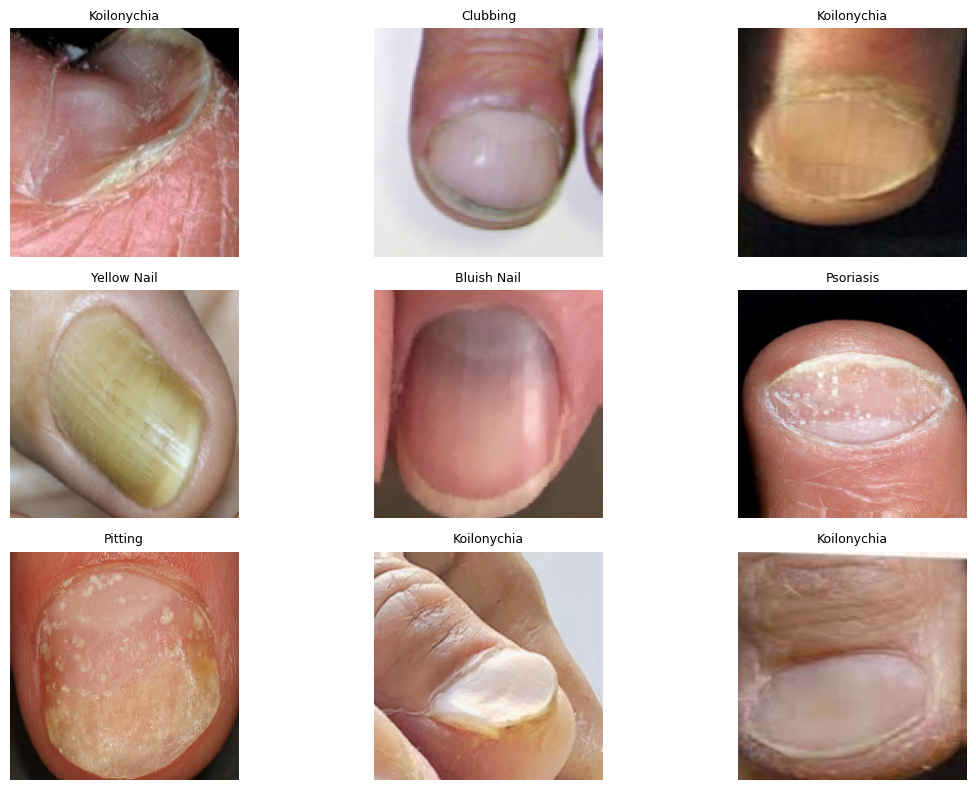

In [26]:
# 🟩 STEP 7: Visualize 9 clean samples
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)


images, labels = next(train_generator) # Use train_generator here
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    label_idx = np.argmax(labels[i])
    label_name = list(train_generator.class_indices.keys())[label_idx] # Use train_generator here
    plt.title(label_name, fontsize=9)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [9]:
# 🟩 STEP 8: Display class labels with numeric indices
for class_name, class_index in train_generator.class_indices.items():
    print(f"{class_index} → {class_name}")

0 → Acral Lentiginous Melanoma
1 → Beau’s Lines
2 → Bluish Nail
3 → Clubbing
4 → Healthy Nail
5 → Koilonychia
6 → Onychogryphosis
7 → Onychomycosis
8 → Pitting
9 → Psoriasis
10 → White Nail (Leukonychia)
11 → Yellow Nail


In [10]:
# 🟩 STEP 8: Build the CNN Model (A simple 3-layer architecture)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Note: The num_classes is 12, as seen in the class indices from your notebook.
num_classes = 12

model = Sequential([
    # 1. Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),

    # 2. Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3. Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 4. Classifier Head
    Flatten(),
    Dropout(0.5), # Regularization to prevent overfitting
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax') # Output layer for 12 classes
])

model.summary()

c:\Users\Harlene\Downloads\decastro\KuCognition-1\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         6,156 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,402,252 (169.38 MB)

 Trainable params: 44,402,252 (169.38 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# 🟩 STEP 9: Compile the Model

# Use Adam optimizer and categorical crossentropy loss for multi-class classification.
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [12]:
# 🟩 STEP 10: Train the Model (Initial Run - includes Nail Color detection)

BATCH_SIZE = 32
EPOCHS = 15 # Start with 15 epochs for a baseline

# Calculate steps based on the total number of samples
steps_per_epoch_train = train_generator.samples // BATCH_SIZE
steps_per_epoch_val = test_generator.samples // BATCH_SIZE

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=steps_per_epoch_val
)

c:\Users\Harlene\Downloads\decastro\KuCognition-1\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.0851 - loss: 3.1709 - val_accuracy: 0.0812 - val_loss: 2.4769
Epoch 2/15
 1/13 ━━━━━━━━━━━━━━━━━━━━ 9s 760ms/step - accuracy: 0.0312 - loss: 2.4962

c:\Users\Harlene\Downloads\decastro\KuCognition-1\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.0312 - loss: 2.4962 - val_accuracy: 0.1500 - val_loss: 2.4736
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 871ms/step - accuracy: 0.1392 - loss: 2.4489 - val_accuracy: 0.1500 - val_loss: 2.4218
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1875 - loss: 2.3064 - val_accuracy: 0.1250 - val_loss: 2.4081
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 873ms/step - accuracy: 0.2191 - loss: 2.2416 - val_accuracy: 0.2562 - val_loss: 2.4117
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.2812 - loss: 2.0981 - val_accuracy: 0.3000 - val_loss: 2.3559
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 897ms/step - accuracy: 0.3093 - loss: 1.9699 - val_accuracy: 0.2562 - val_loss: 2.4330
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.2500 - loss: 2.4388 - val_accuracy: 0.2250 - val_loss: 2.4044
Epoch 9/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 882ms/step - accuracy: 0.3892 - loss: 1.8292 - val_accuracy: 0.2625 - val_

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.2500 - loss: 2.8439
Test Loss: 2.8439
Test Accuracy: 0.2500


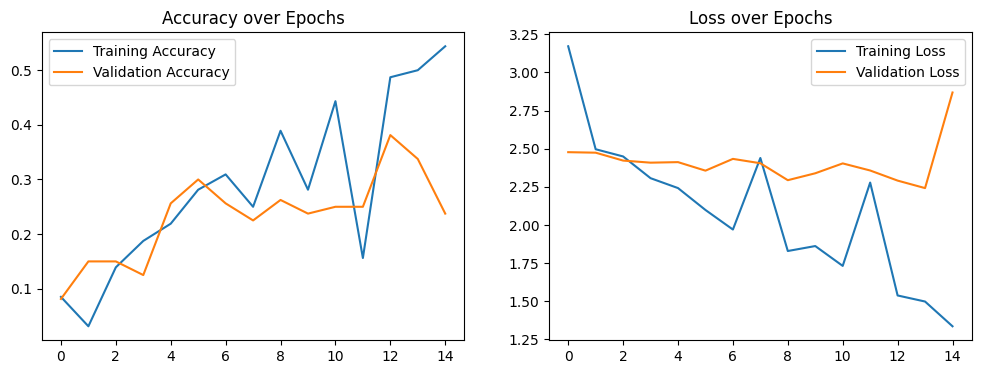

In [13]:
# 🟩 STEP 11a: Evaluate Accuracyy

# Evaluate the final loss and accuracy on the held-out test set
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history for visual inspection (Crucial for hyperparameter adjustment)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# 🟩 STEP 11b: Adjust Hyperparameters (Manual Stepp) 
# Based on the plot:
# - If Val Accuracy is much lower than Training Accuracy (Overfitting), REDUCE complexity or INCREASE Dropout/Regularization.
# - If both are low (Underfitting), INCREASE model complexity (more layers/filters) or INCREASE Epochs.
# - Rerun the training cells (Cell 2 and Cell 3) with adjusted parameters.

In [14]:
# 🟩 STEP 12: Improve for Texture & Shape Recognition using Transfer Learning (VGG16)

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization

# 1. Load VGG16 base model, excluding the top (classification) layer
base_model = VGG16(
    weights='imagenet', # Use weights pre-trained on the ImageNet dataset
    include_top=False,  # Exclude the final classification layer
    input_shape=(224, 224, 3)
)

# 2. Freeze the VGG16 layers (they are excellent feature extractors)
for layer in base_model.layers:
    layer.trainable = False

# 3. Build a new, custom classifier head
x = base_model.output
x = GlobalAveragePooling2D()(x) # Collapse the 3D feature maps into a 1D vector
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x) # Helps stabilize training
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) # Final 12-class output

# 4. Create the final improved model
texture_shape_model = Model(inputs=base_model.input, outputs=predictions)

# 5. Compile the new model with a lower learning rate
texture_shape_model.compile(
    optimizer=Adam(learning_rate=0.0001), # Lower rate prevents destroying pre-trained weights
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

texture_shape_model.summary()

# 6. Train the new model (Optional: uncomment the line below to start training)
# history_vgg = texture_shape_model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // BATCH_SIZE,
#     epochs=10, # Fewer epochs are often needed for transfer learning
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // BATCH_SIZE
# )

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 12)             │         6,15

 Total params: 14,985,548 (57.17 MB)

 Trainable params: 269,836 (1.03 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [32]:
# 🟩 FEATURE EXTRACTION (With File + Disease Name)
import os
import cv2
import numpy as np
import pandas as pd
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 🟩 FEATURE EXTRACTION (With File + Disease Name)
import os
# ... (other imports)

# --- Step 1: Set paths ---
dataset_path = "./content/train"  # <--- Use a local relative path

# --- Step 2: Create image generator to get class labels ---
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    dataset_path, # This is now the corrected local path
    target_size=(150, 150),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# --- Step 3: Define feature extraction functions ---
def extract_ridge_features(img):
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=5)
    ridge_strength = np.mean(np.sqrt(sobelx**2 + sobely**2))
    return ridge_strength

def extract_spot_features(img):
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return len(contours)

def extract_thickness_feature(img):
    gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        c = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(c)
        return h / w if w > 0 else 0
    return 0

def extract_all_features(img):
    return {
        "RIDGE STRENGTH": extract_ridge_features(img),
        "SPOT COUNT": extract_spot_features(img),
        "THICKNESS RATION": extract_thickness_feature(img)
    }

# --- Step 4: Extract features for all images ---
features = []
class_names = list(train_generator.class_indices.keys())

for i in range(len(train_generator)):
    img, label = train_generator[i]
    label_idx = np.argmax(label)
    label_name = class_names[label_idx]
    feats = extract_all_features(img[0])
    filename = train_generator.filenames[i].split('/')[-1]
    features.append({
        "FILENAME": filename,
        "DISEASE": label_name,
        **feats
    })

# --- Step 5: Save all extracted features ---
df = pd.DataFrame(features)
df.to_csv("nail_features.csv", index=False)

# --- Step 6: Print random 5 samples (CORRECTED) ---
random_samples = df.sample(5) 
print(f"✅ Total processed images: {len(df)}")
print("🔍 Random sample of extracted features:\n")
print(random_samples.to_string(index=False))

print("\n✅ Features saved as 'nail_features.csv'")

Found 420 images belonging to 12 classes.
✅ Total processed images: 420
🔍 Random sample of extracted features:

                                                                                   FILENAME         DISEASE  RIDGE STRENGTH  SPOT COUNT  THICKNESS RATION
                 Beau’s Lines\34_PNG_compressed_jpg.rf.45fd44552ae04411538d81e82aa35576.jpg    Beau’s Lines      654.484998          10          0.838710
                                                                      Pitting\34pitting.png         Pitting      472.672643          20          0.739726
Onychomycosis\distal-subungual-onychomycosis-16_jpg.rf.9b2012f059b1582941bb1730294e2c5b.jpg   Onychomycosis      478.922380           2          1.119403
Onychomycosis\distal-subungual-onychomycosis-18_jpg.rf.c2552787dafcb19638f3952da4f71180.jpg   Onychomycosis      562.519402           1          1.153846
                                           Onychogryphosis\Screenshot 2025-10-25 211259.png Onychogryphosis      770.7